In [1]:
%matplotlib inline
import os
import re
import io

import matplotlib
import numpy as np
import pandas as pd
import xarray as xr

import climatools.html.html as climahtml
import climatools.lblnew.g1_threshold as scripts

import IPython.display as display

import imp
imp.reload(scripts)

/chia_cluster/home/jackyu/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


<module 'climatools.lblnew.g1_threshold' from '/chia_cluster/home/jackyu/climatools/climatools/lblnew/g1_threshold.py'>

In [2]:
%run param.py

In [3]:
NG_REFS = PARAM['ng_refs']
P_REFS, T_REFS = zip(*PARAM['ref_pts'])

In [4]:
# for printing some input parameters

def innames():
    return ['vstar', 'nband', 'nv', 'dv',
            'flgh2o',
            'tsfc',
            'pressure_reference_1',
            'temperature_reference_1', 
            'pressure_reference_2', 
            'temperature_reference_2',
            'ighigh', 
            'ng', 
            'nref',
            'p_refs',
            't_refs',
            'ng_refs',
            'ng_adju',
            'absth',
            'wgt',
            'option_wgt_flux',
            'option_wgt_k',
            'option_klin',
            'w_diffuse',
            'fac_meank',
            'klin',
            'option_compute_ktable',
            'option_compute_btable',
            'conc']



def pattern_assign(name):
    return ''' 
    parameter .* :: \s* &? \s* ({} \s* = .* \n)
    '''.format(name)

def pattern_data(name):
    return '''
    (data [^/{name}]+ {name}[^,] [^/{name}]+ / [^/]+ /)
    '''.format(name=name)

def pattern_atmpro():
    return '''
    (atmosphere_profiles/.*75_r8.pro)
    '''
    

def get_input_params(code, names):
    results = []
    for name in names:
        regex = re.compile(pattern_assign(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
        regex = re.compile(pattern_data(name), re.VERBOSE)
        results.extend(regex.findall(code))
        
    regex = re.compile(pattern_atmpro(), re.VERBOSE)
    results.extend(regex.findall(code))
        
    results = [result.replace('_r8', '') for result in results]
    return results


In [5]:
analysis = scripts.Analysis()

In [6]:
crd = analysis.model('crd')
crd.type_model = 'crd'
crd.rundir = DIR_FORTRAN
crd.fpath_flux = 'output_fluxg.dat'
crd.fpath_coolr = 'output_coolrg.dat'
crd.linestyle = '-'
crd.color = 'b'
crd.marker = None
crd.load_data()

In [7]:
def add_wgt_models():
    iggs = [10, 1]
    markers = [None, 'x']
    colors = ['r', 'c']
    linestyle = '-'

    df_wfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                         'output_wfluxg.dat'), 
                            sep=r'\s+')

    df_wcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wcoolrg.dat'), 
                             sep=r'\s+')

    for igg, marker, color in zip(iggs, markers, colors):

        flux_igg = df_wfluxg[df_wfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wcoolrg[df_wcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdx_igg = analysis.model('wgt_igg{}'.format(igg))
        crdx_igg.type_model = 'crd'
        crdx_igg.rundir = DIR_FORTRAN
        crdx_igg.fpath_flux = s_flux
        crdx_igg.fpath_coolr = s_coolr
        crdx_igg.color = color
        crdx_igg.marker = marker
        crdx_igg.linestyle = linestyle
        crdx_igg.load_data()
        
add_wgt_models()

In [8]:
def add_ktable_models():
    iggs = [10]
    markers = ['D',]
    color = 'g'
    linestyle = ':'

    df_wwfluxg = pd.read_csv(os.path.join(crd.rundir, 
                                          'output_wwfluxg.dat'), 
                             sep=r'\s+')

    df_wwcoolrg = pd.read_csv(os.path.join(crd.rundir, 
                                           'output_wwcoolrg.dat'), 
                              sep=r'\s+')

    for igg, marker in zip(iggs, markers):

        flux_igg = df_wwfluxg[df_wwfluxg['igg'] == igg]\
        .drop('igg', axis=1)
        s_flux = io.StringIO(flux_igg.to_csv(sep=' '))

        coolr_igg = df_wwcoolrg[df_wwcoolrg['igg'] == igg]\
        .drop('igg', axis=1)
        s_coolr = io.StringIO(coolr_igg.to_csv(sep=' '))

        crdxx_igg = analysis.model('ktable_igg{}'.format(igg))
        crdxx_igg.type_model = 'crd'
        crdxx_igg.rundir = DIR_FORTRAN
        crdxx_igg.fpath_flux = s_flux
        crdxx_igg.fpath_coolr = s_coolr
        crdxx_igg.color = color
        crdxx_igg.marker = marker
        crdxx_igg.linestyle = linestyle
        crdxx_igg.load_data()
        
        

In [9]:
fig = analysis.fig_fluxcoolr('fig1', vartypes=['cooling rate'])
fig.ggroups = list(crd.data['dgdgs'].coords['g'].values) #list(range(1, 8 + 1))
fig.vars_plot['flux'] = ['flug', 'fnetg']
fig.vars_plot['cooling rate'] = ['coolrg']
fig.colors['flug'] = 'darkred'
fig.colors['fnetg'] = 'lightcoral'
fig.colors['coolrg'] = 'blue'
fig.varlims_from_indexrange['linear'] = (50, 1050)
fig.varlims_from_indexrange['log'] = (1e-2, 200)

fig.set_pressure_displayrange(low=1e-2)

In [10]:
table_fluxg = analysis.table('table_fluxg')
table_fluxg.sumg = False
table_fluxg.vartype = 'flux'
table_fluxg.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolrg = analysis.table('table_coolrg')
table_coolrg.vartype = 'cooling rate'
table_coolrg.sumg = False
table_coolrg.at_pressures = crd.data['cooling rate']\
                               .coords['pressure']\
                               .isel(pressure=[0, -1])


In [11]:
table_flux = analysis.table('table_flux')
table_flux.sumg = True
table_flux.vartype = 'flux'
table_flux.at_pressures = crd.data['flux']\
                             .coords['pressure']\
                             .isel(pressure=[0, -1])

table_coolr = analysis.table('table_coolr')
table_coolr.vartype = 'cooling rate'
table_coolr.sumg = True
table_coolr.at_pressures = crd.data['cooling rate']\
                              .coords['pressure']\
                              .isel(pressure=[0, -1])

In [12]:
table_dgdgs = analysis.table('dgdgs')
table_dgdgs.vartype = 'dgdgs'
table_dgdgs.sumg = False

In [13]:
for name, value in sorted(PARAM.items()):
    print('{} = {}'.format(name, value))

atmpro = mls
band = 7
commitnumber = 043bdfe
conc = 1.8e-06
dv = 0.01
klin = 0
molecule = ch4
ng_adju = [0, 0]
ng_refs = [2, 3]
nv = 100
option_compute_btable = 0
option_compute_ktable = 0
option_wgt_flux = 2
option_wgt_k = 1
ref_pts = [(1, 250), (500, 250)]
tsfc = 294
vmax = 1380
vmin = 1215
w_diffuse = [(1.66, 1.66), (1.66, 1.66, 1.66)]
wgt = [(0.7, 0.7), (0.7, 0.7, 0.7)]


In [14]:
fig.display_hrefanchor()

In [15]:
table_fluxg.display_hrefanchor()
table_coolrg.display_hrefanchor()

table_flux.display_hrefanchor()
table_coolr.display_hrefanchor()

In [16]:
table_dgdgs.display_hrefanchor()

In [17]:
s_abscom = 'Overall absth'
display.HTML(climahtml.getHTML_hrefanchor(s_abscom))

In [18]:
s_ggroup_summary = 'g-group summary'
display.HTML(climahtml.getHTML_hrefanchor(s_ggroup_summary))

In [19]:
#for g in range(1, 20 + 1):
#    s = 'Table: cooling rate. g-group {}'.format(g)
#    html = climahtml.getHTML_hrefanchor(s)
#    display.display(display.HTML(html))

# Figure: cooling rate g-group 1

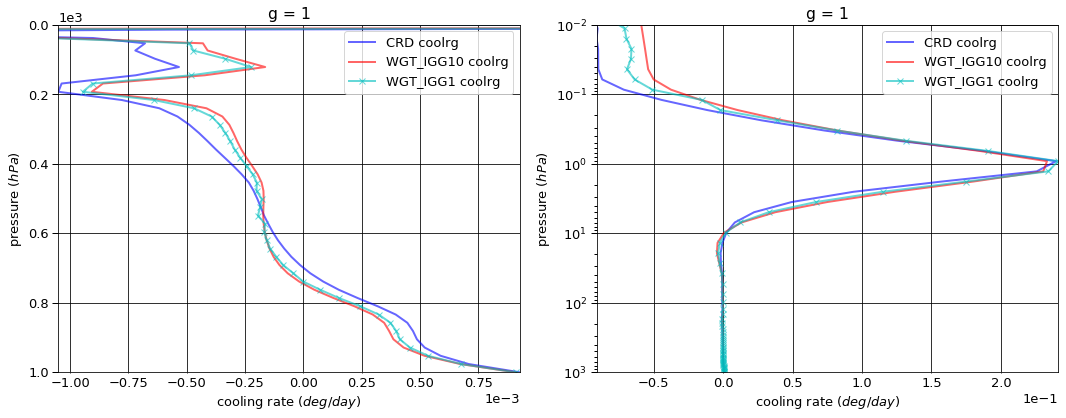

# Figure: cooling rate g-group 2

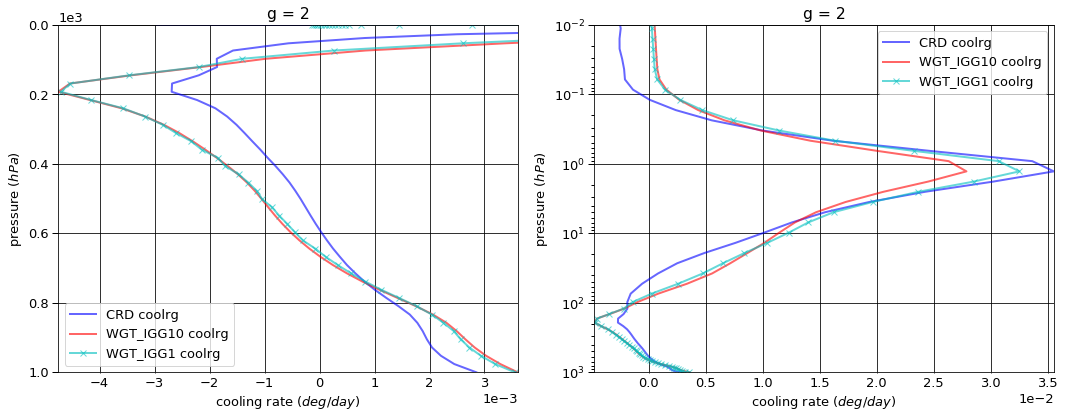

# Figure: cooling rate g-group 3

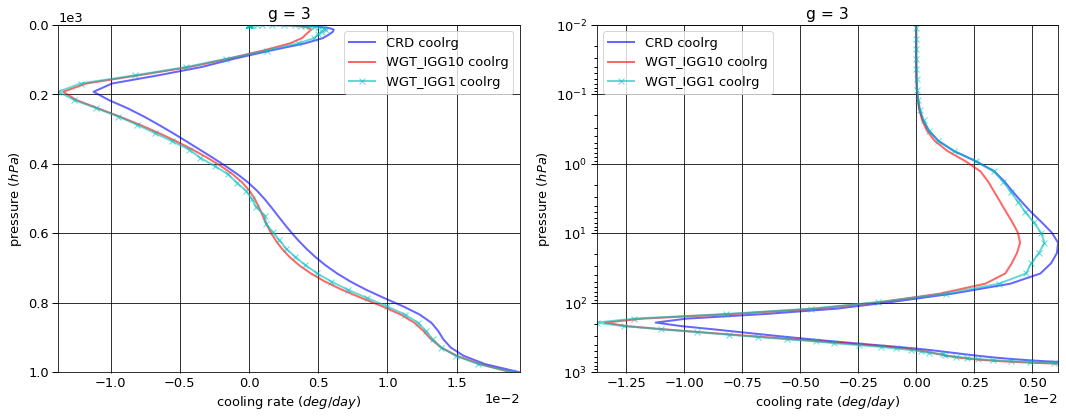

# Figure: cooling rate g-group 4

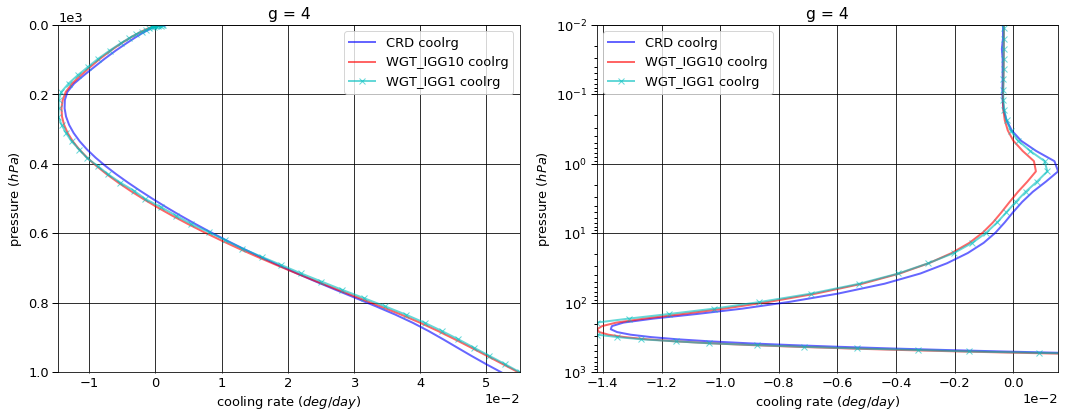

# Figure: cooling rate g-group 5

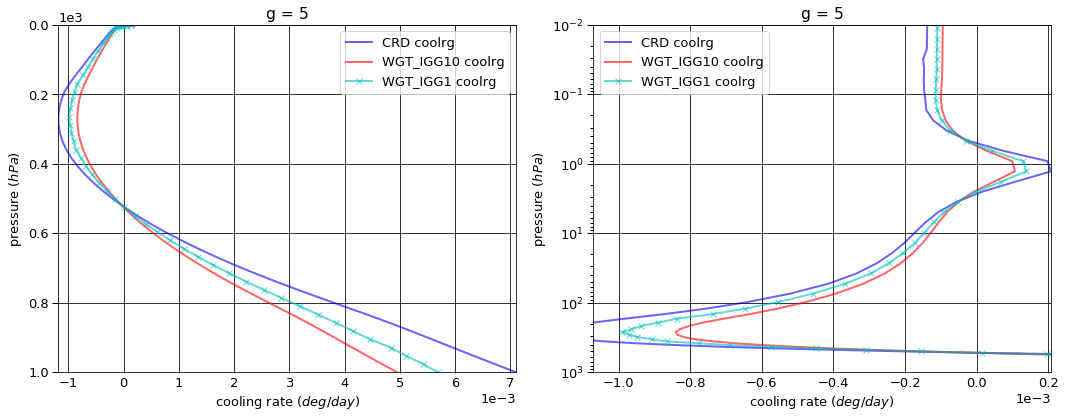

# Figure: cooling rate g-group total

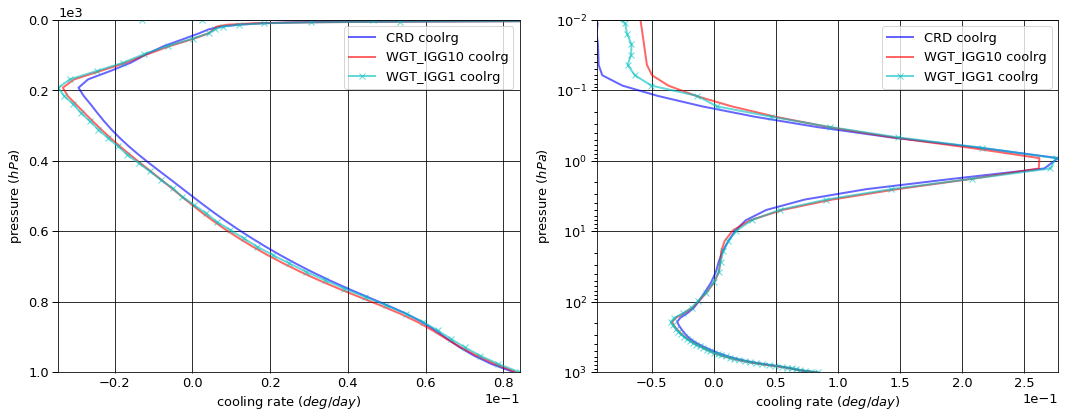

In [20]:
matplotlib.rcParams.update({'font.size': 13,
                            'grid.color': 'black',
                            'axes.facecolor': 'white',
                            'axes.edgecolor': 'black',
                            'ytick.direction': 'out',
                            'ytick.major.size': 6, 'ytick.major.width': 1,
                            'ytick.minor.size': 3, 'ytick.minor.width': 1,
                            'xtick.direction': 'out',
                            'xtick.major.size': 6, 'xtick.major.size': 1,
                            'xtick.minor.size': 3, 'xtick.minor.size': 1}) 

fig.plot(analysis)


In [21]:
table_fluxg.display_withdiff(analysis, benchmark='crd')
table_coolrg.display_withdiff(analysis, benchmark='crd')
table_flux.display_withdiff(analysis, benchmark='crd')
table_coolr.display_withdiff(analysis, benchmark='crd')

# Table: flux. g-groups 


CRD


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.056482  0.000000  -0.056482
  1013.0   76     -0.163044  0.147540  -0.015504
2 0.0      1      -0.211544  0.000000  -0.211544
  1013.0   76     -0.538450  0.345762  -0.192688
3 0.0      1      -0.761175  0.000000  -0.761175
  1013.0   76     -2.801252  2.385678  -0.415574
4 0.0      1     -10.407887  0.000000 -10.407887
  1013.0   76    -12.260656  2.941766  -9.318890
5 0.0      1      -7.835930  0.000000  -7.835930
  1013.0   76     -7.991773  0.303261  -7.688512


WGT_IGG10


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.062153  0.000000  -0.062153
  1013.0   76     -0.163044  0.154640  -0.008403
2 0.0      1      -0.075277  0.000000  -0.075277
  1013.0   76     -0.538450  0.463487  -0.074963
3 0.0      1      -0.477164  0.000000  -0.477164
  1013.0   76     -2.801252  2.526854  -0.274398
4 0.0      1     -10.570052  0.000000 -10.570052
  1013.0   76    -12.260656  2.754031  -9.506625
5 0.0      1      -7.884349  0.000000  -7.884349
  1013.0   76     -7.991773  0.208179  -7.783595


WGT_IGG1


flug      fldg      fnetg
g pressure level                                
1 0.0      1      -0.060765  0.000000  -0.060765
  1013.0   76     -0.163044  0.153625  -0.009419
2 0.0      1      -0.079689  0.000000  -0.079689
  1013.0   76     -0.538450  0.455639  -0.082811
3 0.0      1      -0.520016  0.000000  -0.520016
  1013.0   76     -2.801252  2.489142  -0.312110
4 0.0      1     -10.439023  0.000000 -10.439023
  1013.0   76    -12.260656  2.910235  -9.350421
5 0.0      1      -7.865418  0.000000  -7.865418
  1013.0   76     -7.991773  0.243320  -7.748454


WGT_IGG10 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -5.671059e-03  0.000000 -0.005671
  1013.0   76     0.000000e+00  0.007100  0.007100
2 0.0      1      1.362667e-01  0.000000  0.136267
  1013.0   76     0.000000e+00  0.117725  0.117725
3 0.0      1      2.840103e-01  0.000000  0.284010
  1013.0   76    -4.440892e-16  0.141176  0.141176
4 0.0      1     -1.621650e-01  0.000000 -0.162165
  1013.0   76    -1.776357e-15 -0.187735 -0.187735
5 0.0      1     -4.841870e-02  0.000000 -0.048419
  1013.0   76     0.000000e+00 -0.095082 -0.095082


WGT_IGG1 - CRD


flug      fldg     fnetg
g pressure level                                  
1 0.0      1     -4.282813e-03  0.000000 -0.004283
  1013.0   76     0.000000e+00  0.006085  0.006085
2 0.0      1      1.318554e-01  0.000000  0.131855
  1013.0   76     0.000000e+00  0.109877  0.109877
3 0.0      1      2.411584e-01  0.000000  0.241158
  1013.0   76    -4.440892e-16  0.103464  0.103464
4 0.0      1     -3.113600e-02  0.000000 -0.031136
  1013.0   76    -1.776357e-15 -0.031531 -0.031531
5 0.0      1     -2.948820e-02  0.000000 -0.029488
  1013.0   76     0.000000e+00 -0.059941 -0.059941

# Table: cooling rate. g-groups 


CRD


coolrg
g pressure    layer          
1 0.000312    1     -0.104038
  1001.112500 75     0.000929
2 0.000312    1     -0.002959
  1001.112500 75     0.002852
3 0.000312    1     -0.000012
  1001.112500 75     0.019565
4 0.000312    1     -0.000338
  1001.112500 75     0.052279
5 0.000312    1     -0.000134
  1001.112500 75     0.007107


WGT_IGG10


coolrg
g pressure    layer          
1 0.000312    1     -0.068177
  1001.112500 75     0.000911
2 0.000312    1      0.000180
  1001.112500 75     0.003603
3 0.000312    1     -0.000002
  1001.112500 75     0.018980
4 0.000312    1     -0.000304
  1001.112500 75     0.054866
5 0.000312    1     -0.000092
  1001.112500 75     0.004954


WGT_IGG1


coolrg
g pressure    layer          
1 0.000312    1     -0.080930
  1001.112500 75     0.000912
2 0.000312    1     -0.000128
  1001.112500 75     0.003553
3 0.000312    1     -0.000001
  1001.112500 75     0.019010
4 0.000312    1     -0.000310
  1001.112500 75     0.055080
5 0.000312    1     -0.000107
  1001.112500 75     0.005683


WGT_IGG10 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.035861
  1001.112500 75    -0.000018
2 0.000312    1      0.003139
  1001.112500 75     0.000751
3 0.000312    1      0.000010
  1001.112500 75    -0.000585
4 0.000312    1      0.000035
  1001.112500 75     0.002588
5 0.000312    1      0.000042
  1001.112500 75    -0.002153


WGT_IGG1 - CRD


coolrg
g pressure    layer          
1 0.000312    1      0.023108
  1001.112500 75    -0.000017
2 0.000312    1      0.002831
  1001.112500 75     0.000701
3 0.000312    1      0.000011
  1001.112500 75    -0.000555
4 0.000312    1      0.000028
  1001.112500 75     0.002801
5 0.000312    1      0.000027
  1001.112500 75    -0.001424

# Table: flux. g-groups total


CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-19.273017,0.000000,-19.273017
1013.0,76,-23.755175,6.124007,-17.631168



WGT_IGG10


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-19.068995,0.000000,-19.068995
1013.0,76,-23.755175,6.107191,-17.647985



WGT_IGG1


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,-18.964911,0.000000,-18.964911
1013.0,76,-23.755175,6.251961,-17.503215



WGT_IGG10 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.204022,0.000000,0.204022
1013.0,76,0.000000,-0.016817,-0.016817



WGT_IGG1 - CRD


,,flug,fldg,fnetg
pressure,level,,,
0.0,1,0.308107,0.000000,0.308107
1013.0,76,0.000000,0.127953,0.127953


# Table: cooling rate. g-groups total


CRD


,,coolrg
pressure,layer,
0.000312,1,-0.107482
1001.112500,75,0.082732



WGT_IGG10


,,coolrg
pressure,layer,
0.000312,1,-0.068395
1001.112500,75,0.083314



WGT_IGG1


,,coolrg
pressure,layer,
0.000312,1,-0.081477
1001.112500,75,0.084237



WGT_IGG10 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.039087
1001.112500,75,0.000582



WGT_IGG1 - CRD


,,coolrg
pressure,layer,
0.000312,1,0.026005
1001.112500,75,0.001505


In [22]:
table_dgdgs.display_dgdgs(crd)

# Table: dgdgs. g-groups 

,dg,dgs
g,,
1,0.007091,0.006780
2,0.023030,0.022526
3,0.120788,0.116775
4,0.523030,0.513605
5,0.326061,0.340315


In [23]:
# read and display overall absth
display.display(
    display.HTML(climahtml.getHTML_idanchor(s_abscom)))
display.display(
    display.Markdown(climahtml.getMarkdown_sectitle(s_abscom)))

display.display(pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'),
                sep=r'\s+',
                index_col=[0]))

# Overall absth

,abscom
g,
1,5.458432e-19
2,1.171722e-20
3,4.063332e-20
4,1.470098e-21
5,5.318760e-23


In [24]:
def spreadsheet(ng_refs, p_refs):
    ng = crd.data['dgdgs'].dims['g']
    
    df_abscom = pd.read_csv(os.path.join(crd.rundir, 'abscom.dat'), 
                            sep=r'\s+', index_col=[0])
    
    # absth(g + 1) / absth(g)
    df_abscom_copy = df_abscom.copy()
    df_abscom_copy.index = df_abscom.index + 1
    df_absratio = df_abscom / df_abscom_copy
    df_absratio.columns = ['k(ig) / k(ig - 1)']
    df_absratio = df_absratio.loc[: ng]
    df_dgdgs = crd.data['dgdgs'].to_dataframe()
    
    
    df_dgdgs_cumsum = df_dgdgs.cumsum(axis=0)
    df_dgdgs_cumsum.columns = ['dg cumsum', 'dgs cumsum']
    
    data_pref = np.concatenate([p_ref * np.ones((ng_ref,)) 
                                for ng_ref, p_ref 
                                in zip(ng_refs, p_refs)], axis=0)
    df_pref = pd.DataFrame(data_pref, 
                           index=df_dgdgs.index, columns=['pref'])
    
    df_all = pd.concat([df_abscom, df_absratio,
                        df_dgdgs, df_dgdgs_cumsum,
                        df_pref], axis=1) 
    return df_all
    

In [25]:
display.display(display.HTML(climahtml.getHTML_idanchor(s_ggroup_summary)))
display.display(display.Markdown(climahtml.getMarkdown_sectitle(s_ggroup_summary)))
display.display(spreadsheet(NG_REFS, P_REFS))

# g-group summary

,abscom,k(ig) / k(ig - 1),dg,dgs,dg cumsum,dgs cumsum,pref
g,,,,,,,
1,5.458432e-19,NaN,0.007091,0.006780,0.007091,0.006780,1.0
2,1.171722e-20,0.021466,0.023030,0.022526,0.030121,0.029306,1.0
3,4.063332e-20,3.467830,0.120788,0.116775,0.150909,0.146081,500.0
4,1.470098e-21,0.036180,0.523030,0.513605,0.673939,0.659685,500.0
5,5.318760e-23,0.036180,0.326061,0.340315,1.000000,1.000000,500.0


In [26]:
def load_d_bigsum():
    
    ng = 10
    
    fpath = os.path.join(crd.rundir, 'd_bigsum.dat')
    df = pd.read_csv(fpath, sep=r'\s+', index_col = [0, 1])

    g_layers = [(1, 62), (2, 58)]
    
    writer = pd.ExcelWriter('_'.join(['d_bigsum_absgas',
                                      'ng_{}'.format(ng)])
                            + '.xlsx')
    for g, layer in g_layers:
        df.loc[(g, layer), :].to_excel(writer, 
                                       '({}, {})'.format(g, layer))
        

#load_d_bigsum()

In [27]:
display.HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')
